# References:

BitBIRCH: https://pubs.rsc.org/en/content/articlelanding/2025/dd/d5dd00030k

BitBIRCH-Lean: https://www.biorxiv.org/content/10.1101/2025.10.22.684015v1

GitHub: https://github.com/mqcomplab/bblean

# BitBIRCH-Lean: chemical space in the palm of your workstation

**What is BitBIRCH-Lean?**

* BitBIRCH-Lean is a fast, memory-efficient implementation of the Bit-BIRCH algorithm, designed for high-throughput clustering of huge molecular libraries (up to billions of drug-like molecules) on typical workstations.

* BitBIRCH-Lean considerably improves on the original BitBIRCH implementation by incorporating dynamic types and bit-packed fingerprints inside the clustering tree.

* Most operations in BitBIRCH-Lean are efficiently performed on compressed data, and optional C++ extension accelerate the bottleneck calculations, providing up to 2X speedup.

* Benchmark tests against GPU-accelerated methods highlight BitBIRCH-Lean as an efficient alternative for processing vast amounts of molecules.

* A parallel, multi-round variant of the Bit-BIRCH algorithm that exploits the gains in efficiency to cluster hundreds of millions of molecules in minutes, with no loss in cluster quality.

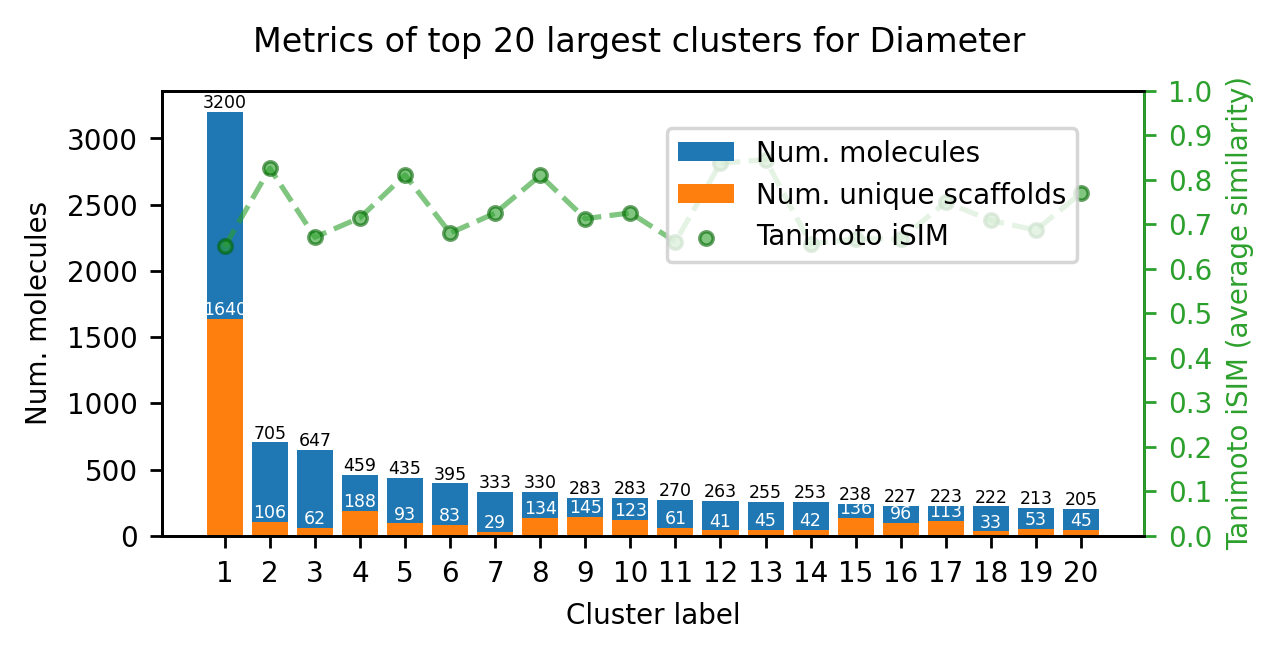

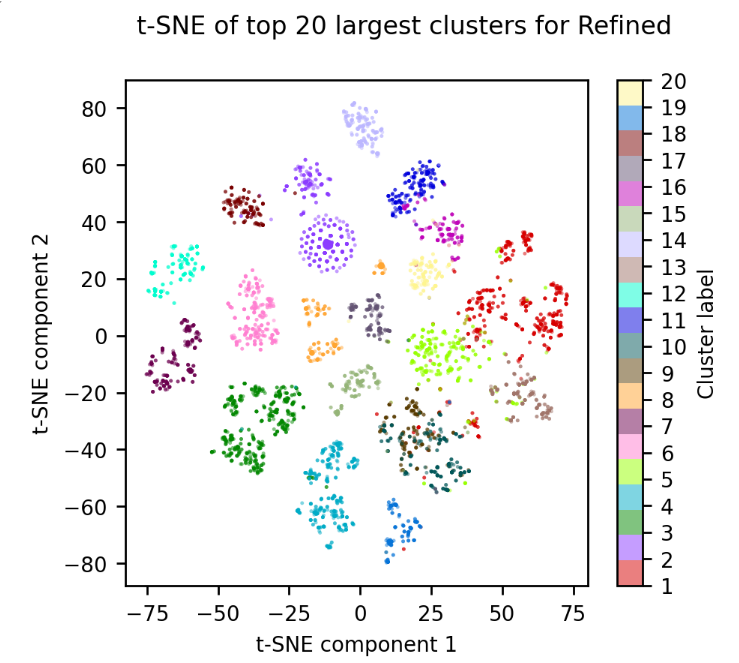

# Set Up

First lets install the BitBirch-Lean package (if you have not already done so). To do this, run the following commands in your terminal:

In [ ]:
import os
!git clone https://github.com/mqcomplab/bblean.git
os.chdir('bblean')
!pip install -v .

Cloning into 'bblean'...
remote: Enumerating objects: 4604, done.
remote: Counting objects: 100% (1572/1572), done.
remote: Compressing objects: 100% (341/341), done.
remote: Total 4604 (delta 1486), reused 1231 (delta 1231), pack-reused 3032 (from 2)
Receiving objects: 100% (4604/4604), 25.59 MiB | 12.92 MiB/s, done.
Resolving deltas: 100% (3310/3310), done.
Using pip 24.1.2 from /usr/local/lib/python3.12/dist-packages/pip (python 3.12)
Processing /content/bblean
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.12/dist-packages/pip (python 3.12)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-mga0y5ge
  Entered build tracker: /tmp/pip-build-tracker-mga0y5ge
  Created temporary directory: /tmp/pip-install-2z3rswgd
  Created temporary directory: /tmp/pip-ephem-wheel-cache-fujpse2i
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching proj

Lets import the bblean package and some bblean modules, which we will use throughout this example.

In [ ]:
import bblean
import bblean.plotting as plotting
import bblean.analysis as analysis

/usr/local/lib/python3.12/dist-packages/bblean/similarity.py:100: UserWarning: C++ optimized similarity calculations not available, falling back to python implementation
  warnings.warn(


Now let’s take some SMILES strings and compute molecular fingerprints:

In [ ]:
smiles = bblean.load_smiles("/content/bblean/examples/chembl-33-natural-products-subset.smi")

# By default the fps created are of the "ecfp4" kind. Here we use "rdkit"
fps = bblean.fps_from_smiles(smiles, pack=True, n_features=2048, kind="rdkit")
print(f"Shape: {fps.shape}, DType: {fps.dtype}")

Shape: (64086, 256), DType: uint8


The most efficient way to store and manipulate fingerprints is using packed fingerprint arrays. Packed arrays save the features in a compressed representation. To convert between packed and unpacked fingerprints you can use bblean.pack_fingerprints(fps) and bblean.unpack_fingerprints(fps).

In [ ]:
fps_unpacked = bblean.unpack_fingerprints(fps)
print(f"Shape unpacked: {fps_unpacked.shape}, DType unpacked: {fps_unpacked.dtype}")

fps = bblean.pack_fingerprints(fps_unpacked)
print(f"Shape re-packed: {fps.shape}, DType re-packed: {fps.dtype}")

Shape unpacked: (64086, 2048), DType unpacked: uint8
Shape re-packed: (64086, 256), DType re-packed: uint8


# Clustering fingerprints

Now lets create a BitBirch object, which we can use to cluster the (packed) fingerprints

In [ ]:
# Initialize the BitBirch tree. In general, diameter is the best merge criterion for
# initial clustering. For more info consult the *refinement* paper.
# 0.5-0.65 is a good threshold range for "rdkit" fingerprints, for ecfp4 use 0.3-0.4 instead
bb_tree = bblean.BitBirch(branching_factor=50, threshold=0.65, merge_criterion="diameter")

# Cluster the packed fingerprints (By default all bblean functions take packed
# fingerprints)
bb_tree.fit(fps)

BitBirch(threshold=0.65, branching_factor=50, merge_criterion='diameter')

Finally, lets visualize the clustering results:

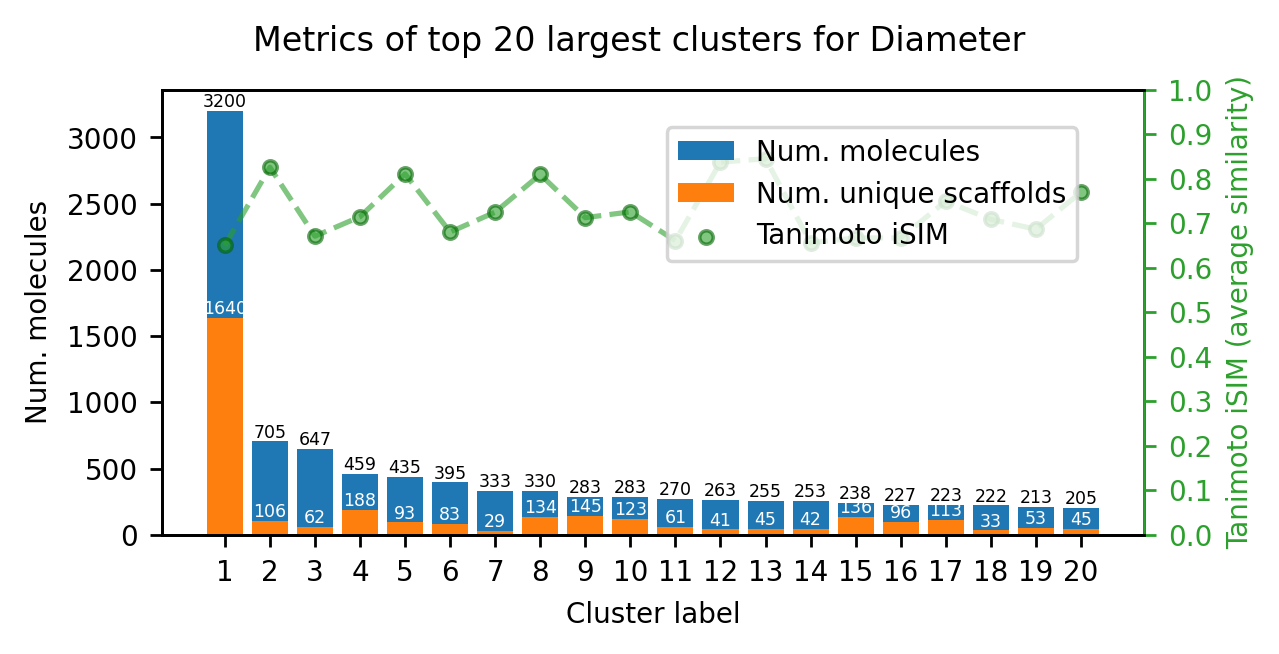

In [ ]:
import matplotlib.pyplot as plt

# First we run a cluster analysis on the resulting ids
clusters = bb_tree.get_cluster_mol_ids()
ca = analysis.cluster_analysis(clusters, fps, smiles)

# Afterwards we can use the utility functions on the bblean.plotting module
plotting.summary_plot(ca, title="Diameter")

# Optionally we can save the cluster analysis metrics as a csv file
ca.dump_metrics("./diameter-metrics.csv")
plt.show()

Lets inspect some features of the generated clusters, which we can get directly from the resulting “cluster analaysis”

In [ ]:
# Total clusters
print("Number of clusters: ", ca.all_clusters_num)

# Clusters with more than 10 molecules
print("Number of clusters with more than 10 molecules: ", ca.all_clusters_num_with_size_above(10))

# Singletons (clusters with a single element)
print("Number of singletons", ca.all_singletons_num)

Number of clusters:  14346
Number of clusters with more than 10 molecules:  964
Number of singletons 8447


# Refining the clustering results


Sometimes you may get a pretty big cluster with a large number of scaffolds, which is undesirable. If this happens, you may want to refine the tree by breaking appart the largest cluster and re-inserting all the bit features. This step is only required if your results display this problem. If they don’t, you are done, no need to refine.

For the refinement, we will use the 'tolerance-diameter' merge criterion, and a tolerance value of 0.0. BitBirch.set_merge(...) can be used to specify the new criterion, and BitBirch.refine_inplace(...) breaks apart the largest cluster and regenerates the tree with our new criterion.

In [ ]:
# Modify the merge criteria for the tree, from now on bb_tree will use this new criteria
bb_tree.set_merge(criterion="tolerance-diameter", tolerance=0.0)

# Refine the tree using the new merge criteria
bb_tree.refine_inplace(fps)

BitBirch(threshold=0.65, branching_factor=50, merge_criterion='tolerance-diameter', tolerance=0.0)

Lets visualize the refined results:

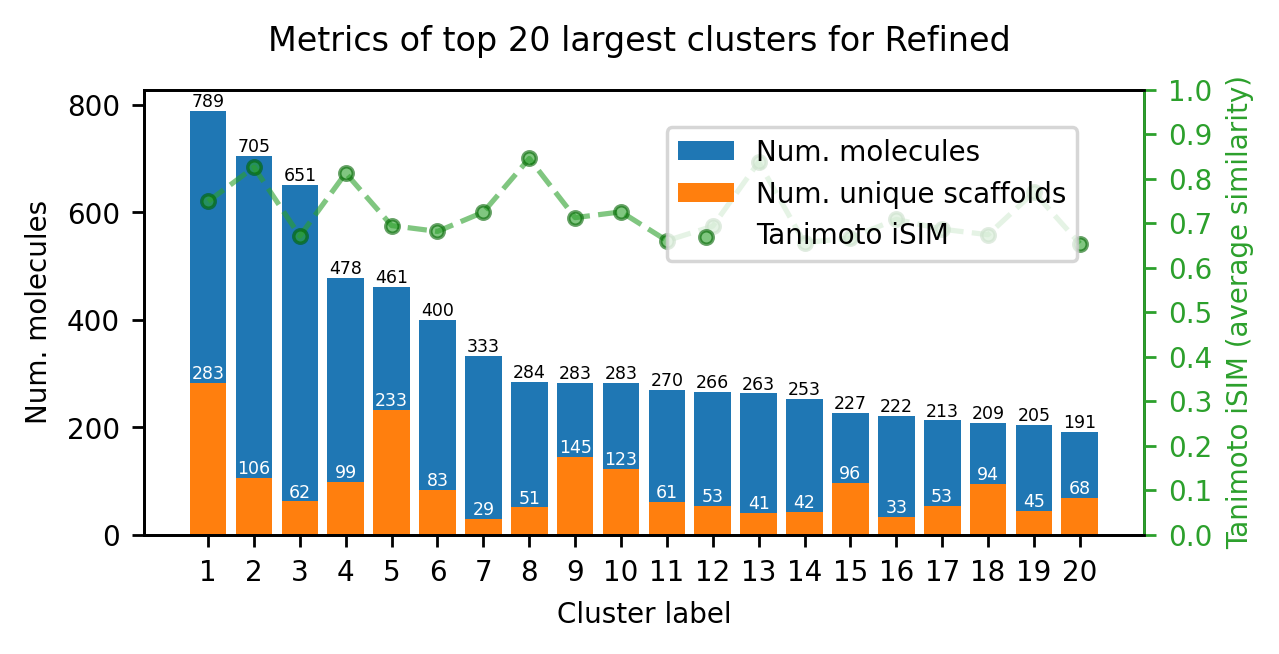

In [ ]:
clusters_refined = bb_tree.get_cluster_mol_ids()
ca_refined = analysis.cluster_analysis(clusters_refined, fps, smiles)
plotting.summary_plot(ca_refined, title="Refined")

# Again, we can save the cluster analysis metrics as a csv file
ca.dump_metrics("./refined-metrics.csv")
plt.show()

In [ ]:
# Total clusters
print("Number of clusters: ", ca_refined.all_clusters_num)

# Clusters with more than 10 molecules
print("Number of clusters with more than 10 molecules: ", ca_refined.all_clusters_num_with_size_above(10))

# Singletons (clusters with a single element)
print("Number of singletons", ca_refined.all_singletons_num)

Number of clusters:  14735
Number of clusters with more than 10 molecules:  966
Number of singletons 7755


# Further analysis and Visualization

Lets inspect some features of the generated clusters:

We can visually inspect an individual cluster by calling plotting.dump_mol_images. By default this generates multiple images with 30 molecules each.

In [ ]:
import os

output_dir = "/content/bblean"
os.makedirs(output_dir, exist_ok=True)

original_dir = os.getcwd()
os.chdir(output_dir)

plotting.dump_mol_images(smiles, clusters_refined, cluster_idx=10)

os.chdir(original_dir)

We can also visualize the clusters using a t-SNE plot with plotting.tsne_plot:

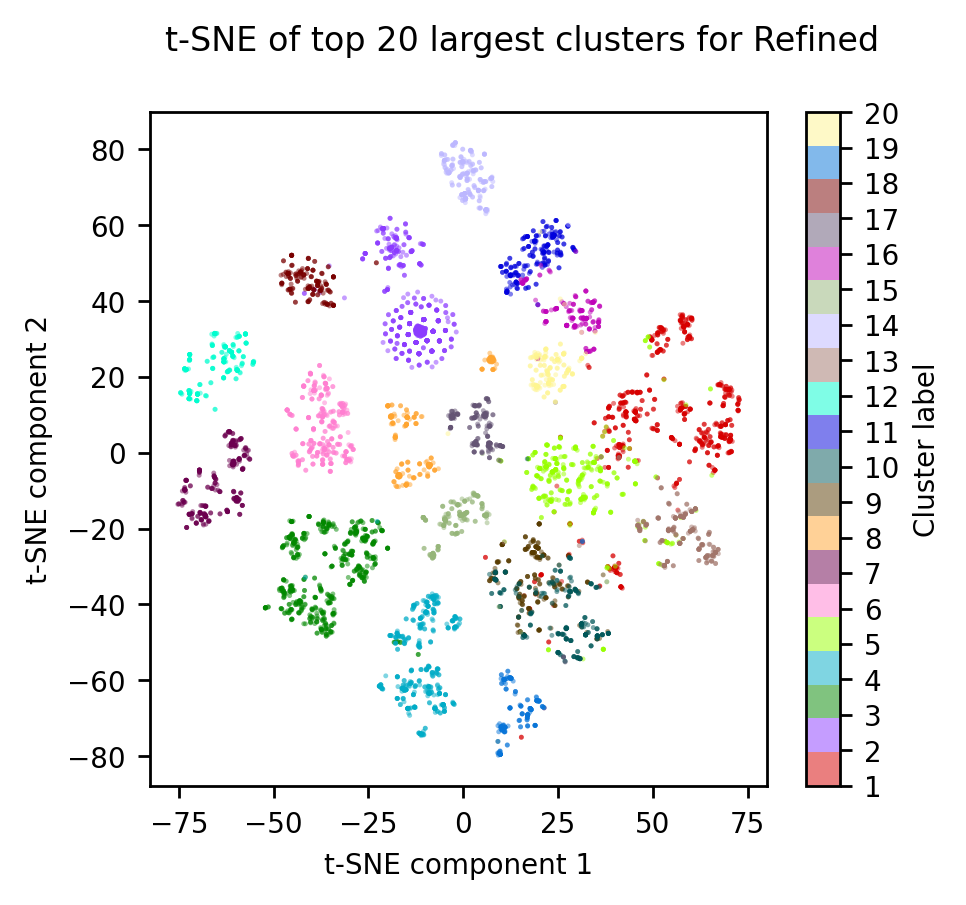

In [ ]:
plotting.tsne_plot(ca_refined, title="Refined")
plt.show()

Dropdown(description='Select PNG:', index=6, options=('/content/bblean/cluster_10_3.png', '/content/bblean/clu…

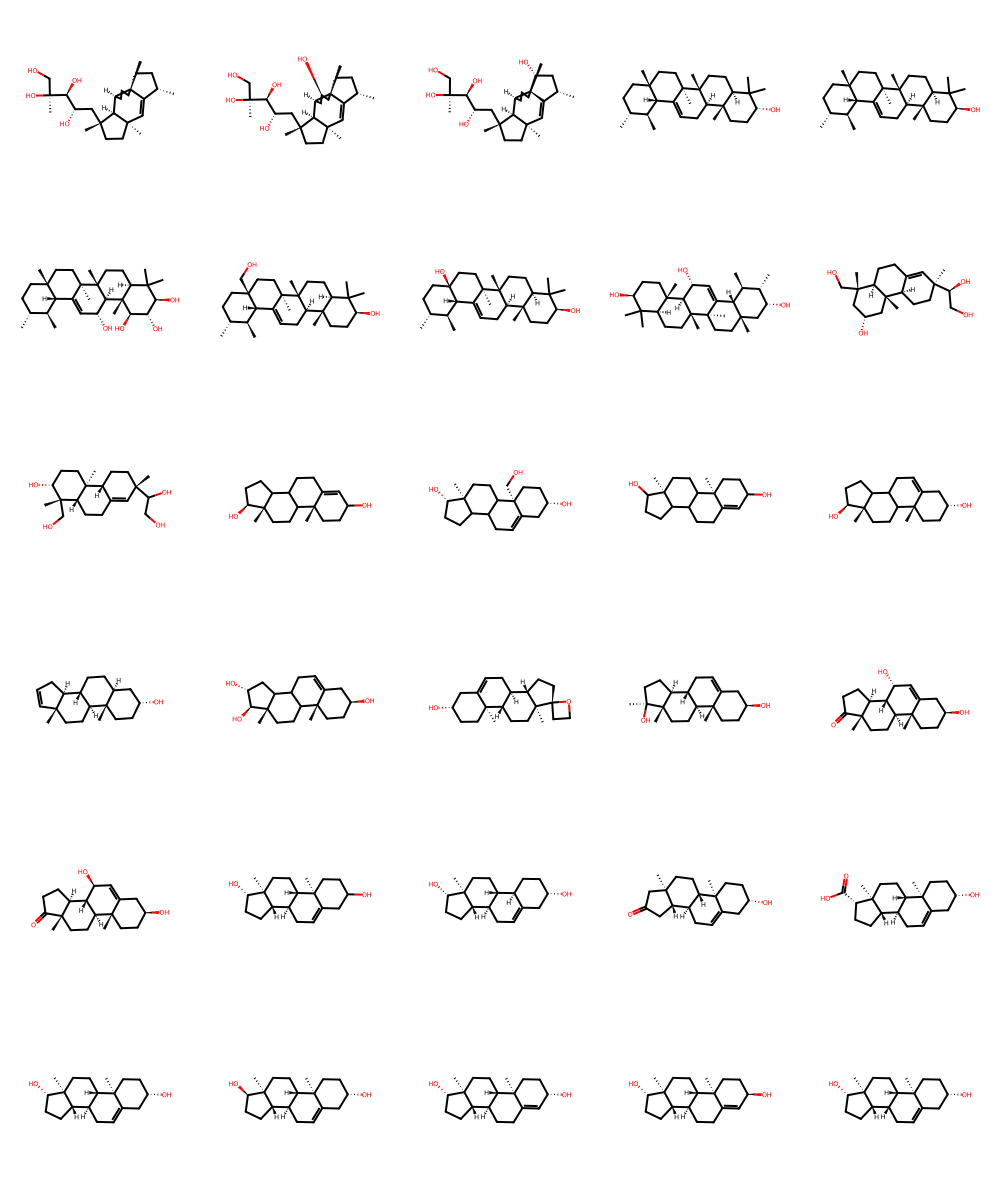

In [ ]:
#@title Visually inspect an individual cluster
import glob
from IPython.display import Image, display
import ipywidgets as widgets
from IPython.display import clear_output
import os

# Define the directory path where the latest clustering images were saved
output_dir = "/content/bblean"

# Get all PNG files in the specified output directory
png_files = glob.glob(os.path.join(output_dir, '*.png'))

if not png_files:
    print(f"No PNG files found in the directory: {output_dir}")
else:
    # Create a dropdown widget
    dropdown = widgets.Dropdown(
        options=png_files,
        description='Select PNG:',
        disabled=False,
    )

    # Function to display the selected image
    def on_dropdown_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            clear_output(wait=True)
            display(dropdown)
            display(Image(filename=change['new']))

    dropdown.observe(on_dropdown_change)

    display(dropdown)
    # Display the first image by default
    display(Image(filename=png_files[0]))

Once we are happy with the clustering results, we can save the final cluster assignments. to a *.csv file.

In [ ]:
bb_tree.dump_assignments("smiles-assignments.csv", smiles)

# Real World Example: Clustering A Custom Designed Combinatorial Library for Virtual Screening and Synthesis

Here we use a combinatorial chemistry library from the previous virtual screening project:

In [ ]:
!wget https://github.com/TomK-cpu/COVID-RNN-Virtual-Screen/raw/main/exit5_products_combined_stream_sh0of1.txt -P /content/

--2025-11-03 14:28:49--  https://github.com/TomK-cpu/COVID-RNN-Virtual-Screen/raw/main/exit5_products_combined_stream_sh0of1.txt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TomK-cpu/COVID-RNN-Virtual-Screen/main/exit5_products_combined_stream_sh0of1.txt [following]
--2025-11-03 14:28:49--  https://raw.githubusercontent.com/TomK-cpu/COVID-RNN-Virtual-Screen/main/exit5_products_combined_stream_sh0of1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2048571 (2.0M) [text/plain]
Saving to: ‘/content/exit5_products_combined_stream_sh0of1.txt’

exit5_products_comb 100%[===================>]   1.

In [ ]:
import pandas as pd

# Load SMILES from the downloaded text file
smiles_data_txt = bblean.load_smiles("/content/exit5_products_combined_stream_sh0of1.txt")

# Separate header from data
header = smiles_data_txt[0].strip().split(',')
smiles_data = [s.strip().split(',') for s in smiles_data_txt[1:]]

# Create a pandas DataFrame from the processed data
df_smiles = pd.DataFrame(smiles_data, columns=header)

# Define the path for the new CSV file
output_csv_path = "/content/exit5_products_combined_stream_sh0of1.csv"

# Save the DataFrame to a CSV file
df_smiles.to_csv(output_csv_path, index=False)

# Save only the SMILES column to a .smi file
smiles_only_path = "/content/exit5_products_combined_stream_sh0of1.smi"
df_smiles['SMILES'].to_csv(smiles_only_path, index=False, header=False)

print(f"SMILES data successfully converted and saved to {output_csv_path} and {smiles_only_path}")

SMILES data successfully converted and saved to /content/exit5_products_combined_stream_sh0of1.csv and /content/exit5_products_combined_stream_sh0of1.smi


In [ ]:
smiles = bblean.load_smiles("/content/exit5_products_combined_stream_sh0of1.smi")

# By default the fps created are of the "ecfp4" kind. Here we use "rdkit"
fps = bblean.fps_from_smiles(smiles, pack=True, n_features=2048, kind="rdkit")
print(f"Shape: {fps.shape}, DType: {fps.dtype}")

Shape: (30367, 256), DType: uint8


In [ ]:
bb_tree = bblean.BitBirch(branching_factor=50, threshold=0.65, merge_criterion="diameter")
bb_tree.fit(fps)

BitBirch(threshold=0.65, branching_factor=50, merge_criterion='diameter')

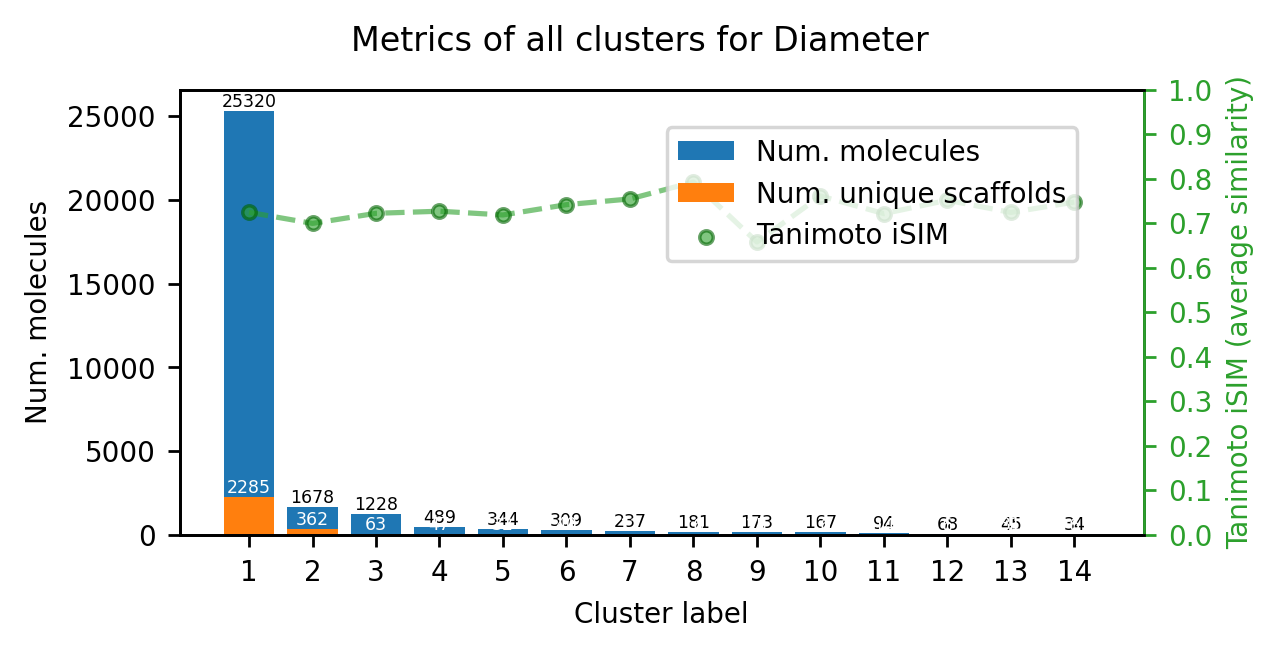

In [ ]:
import matplotlib.pyplot as plt

# First we run a cluster analysis on the resulting ids
clusters = bb_tree.get_cluster_mol_ids()
ca = analysis.cluster_analysis(clusters, fps, smiles)

# Afterwards we can use the utility functions on the bblean.plotting module
plotting.summary_plot(ca, title="Diameter")

# Optionally we can save the cluster analysis metrics as a csv file
ca.dump_metrics("./exit5_products_combined_stream_sh0of1_diameter-metrics.csv")
plt.show()

Here we have a big cluster with a large number of scaffolds, which is undesirable. Let's refine the tree by breaking appart the largest cluster and re-inserting all the bit features.

For the refinement, we will use the 'tolerance-diameter' merge criterion, and a tolerance value of 0.0. BitBirch.set_merge(...) can be used to specify the new criterion, and BitBirch.refine_inplace(...) breaks apart the largest cluster and regenerates the tree with our new criterion.

In [ ]:
# Modify the merge criteria for the tree, from now on bb_tree will use this new criteria
bb_tree.set_merge(criterion="tolerance-diameter", tolerance=0.0)

# Refine the tree using the new merge criteria
bb_tree.refine_inplace(fps)

BitBirch(threshold=0.65, branching_factor=50, merge_criterion='tolerance-diameter', tolerance=0.0)

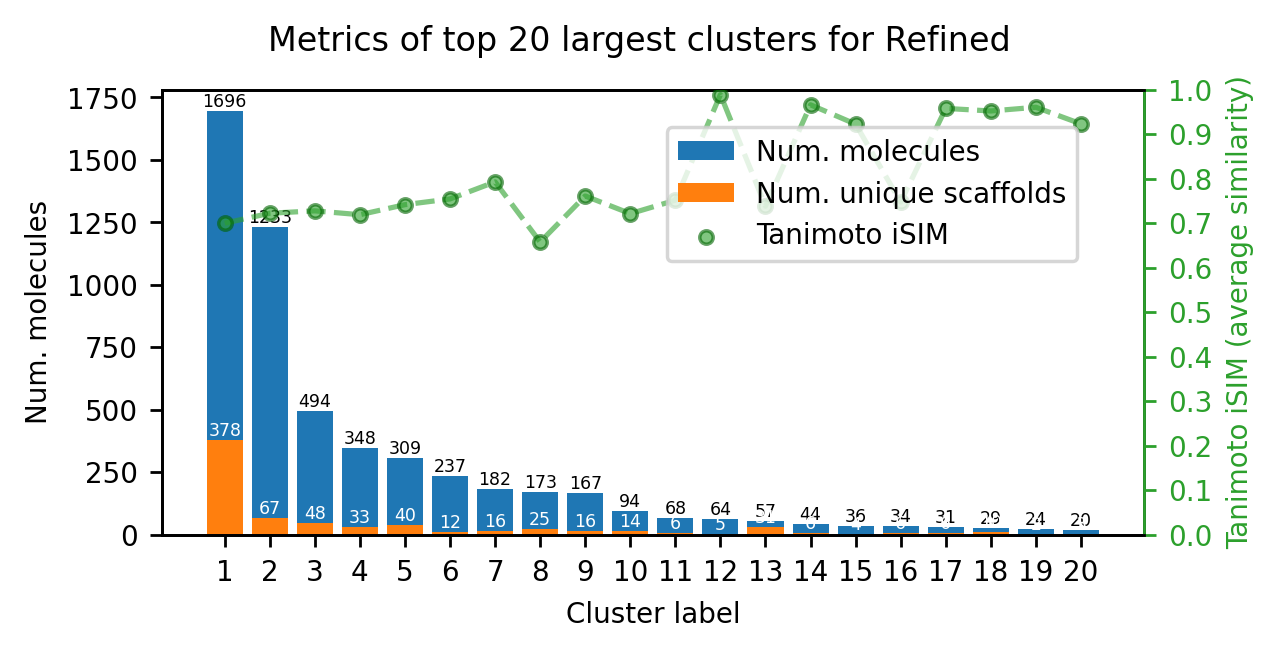

In [ ]:
import matplotlib.pyplot as plt
import os

clusters_refined = bb_tree.get_cluster_mol_ids()
ca_refined = analysis.cluster_analysis(clusters_refined, fps, smiles)

# Define the output directory path
output_dir = "/content/exit5_products_combined_stream_sh0of1"

# Create the directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# Save the summary plot to the specified output directory
plotting.summary_plot(ca_refined, title="Refined")
plt.savefig(os.path.join(output_dir, "summary_plot_refined.png"))

# Save the cluster analysis metrics as a csv file
ca.dump_metrics(os.path.join(output_dir, "refined-metrics.csv"))
plt.show()

In [ ]:
# Total clusters
print("Number of clusters: ", ca_refined.all_clusters_num)

# Clusters with more than 10 molecules
print("Number of clusters with more than 10 molecules: ", ca_refined.all_clusters_num_with_size_above(10))

# Singletons (clusters with a single element)
print("Number of singletons", ca_refined.all_singletons_num)

Number of clusters:  9644
Number of clusters with more than 10 molecules:  90
Number of singletons 2117


In [ ]:
import os

output_dir = "/content/exit5_products_combined_stream_sh0of1"
os.makedirs(output_dir, exist_ok=True)

original_dir = os.getcwd()
os.chdir(output_dir)

# Get the list of all cluster IDs to determine how many clusters there are
clusters_refined = bb_tree.get_cluster_mol_ids()

# Limit to the first 5 clusters for demonstration, you can adjust this range
num_clusters_to_dump = min(5, len(clusters_refined))

for i in range(num_clusters_to_dump):
    plotting.dump_mol_images(smiles, clusters_refined, cluster_idx=i)

os.chdir(original_dir)
print(f"Generated images for {num_clusters_to_dump} clusters in {output_dir}")

Generated images for 5 clusters in /content/exit5_products_combined_stream_sh0of1


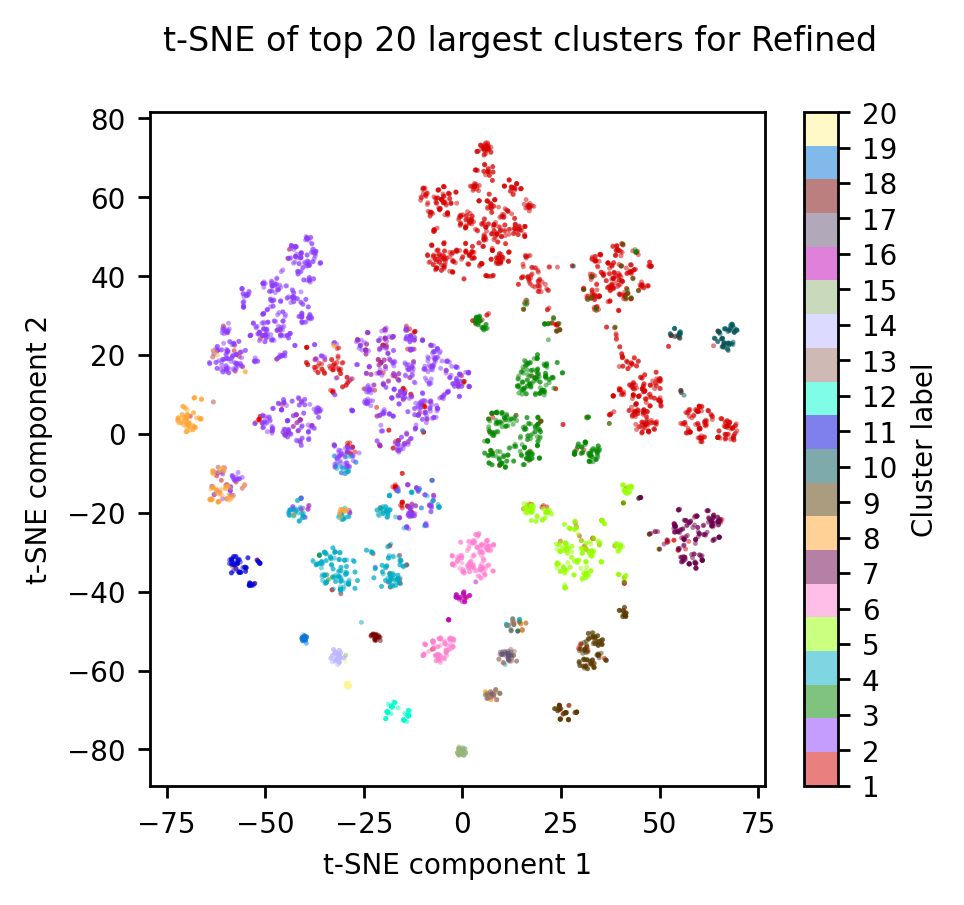

In [ ]:
plotting.tsne_plot(ca_refined, title="Refined")
plt.show()

Dropdown(description='Select PNG:', index=43, options=('/content/exit5_products_combined_stream_sh0of1/cluster…

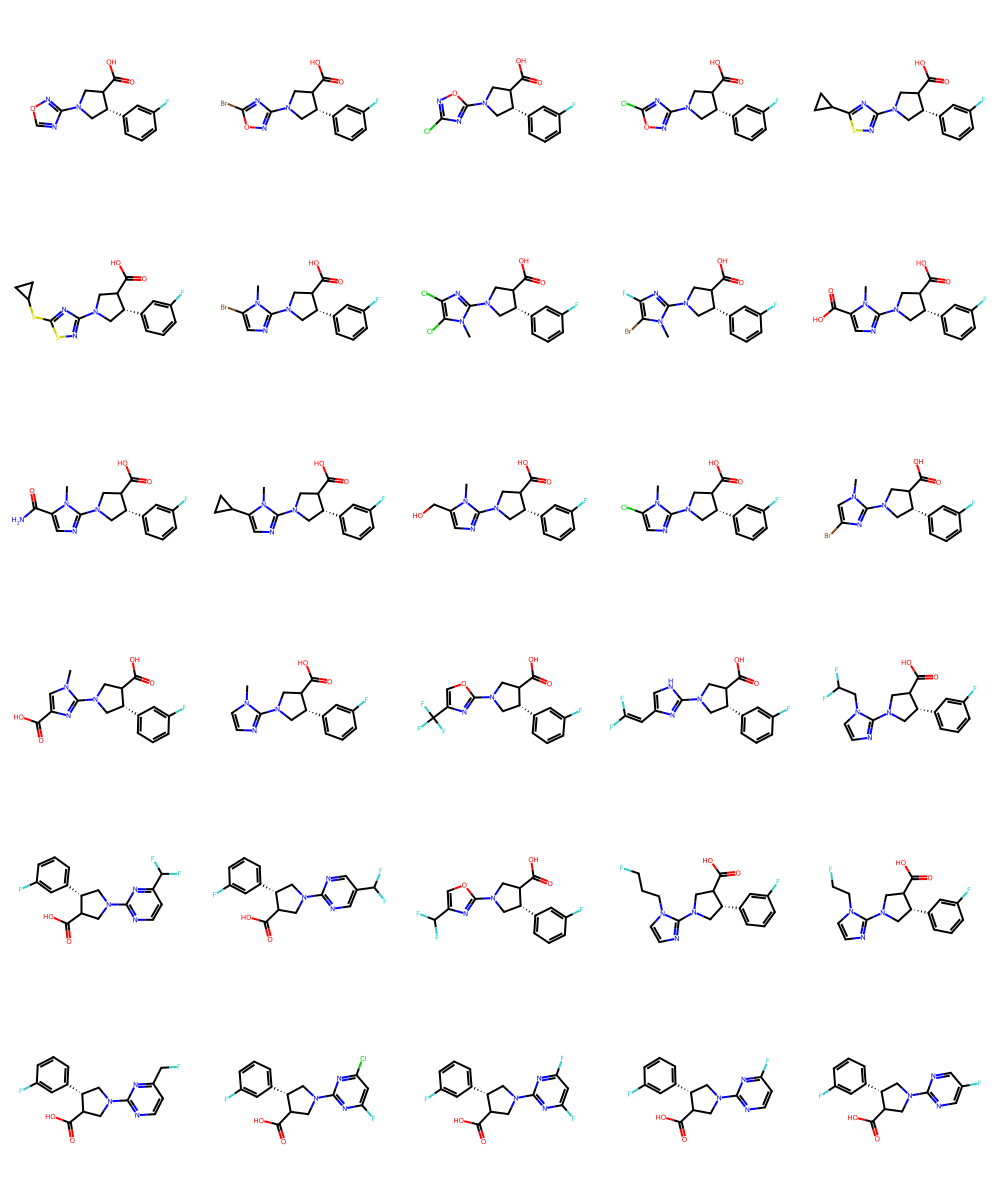

In [ ]:
#@title Visually inspect an individual cluster
import glob
from IPython.display import Image, display
import ipywidgets as widgets
from IPython.display import clear_output
import os

# Define the directory path where the latest clustering images were saved
output_dir = "/content/exit5_products_combined_stream_sh0of1"

# Get all PNG files in the specified output directory
png_files = glob.glob(os.path.join(output_dir, '*.png'))

if not png_files:
    print(f"No PNG files found in the directory: {output_dir}")
else:
    # Create a dropdown widget
    dropdown = widgets.Dropdown(
        options=png_files,
        description='Select PNG:',
        disabled=False,
    )

    # Function to display the selected image
    def on_dropdown_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            clear_output(wait=True)
            display(dropdown)
            display(Image(filename=change['new']))

    dropdown.observe(on_dropdown_change)

    display(dropdown)
    # Display the first image by default
    display(Image(filename=png_files[0]))

In [ ]:
bb_tree.dump_assignments("/content/exit5_products_combined_stream_sh0of1/exit5_products_combined_stream_sh0of1_smiles-assignments.csv", smiles)